In [39]:
import os, glob, shutil, cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy.optimize import curve_fit
from scipy.stats import linregress
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold, threshold_minimum
import skimage.measure as measure

In [14]:
#find videos
print(f'Current directory: {os.getcwd()}')

path_to_videos = glob.glob(os.path.join('Videos','*.avi'))
print(path_to_videos, '-'*10, sep = '\n')
#create required directories
def makefolders(path):
    folder = os.path.split(path) #create folders for extracting all images
    folder = os.path.splitext(folder[-1])
    folder_create = os.path.join('Videos',folder[0])
    if os.path.exists(folder_create) == False:
        os.mkdir(folder_create)
    else:
        pass
    return folder_create

#navigate into folder for the image and save images
def saveimages(path, dir_name):
    cam = cv2.VideoCapture(path)
    count, success = 0, True
    video_index = []
    while success:
        success, image = cam.read()
        if not cam.isOpened():
            print(f"Error: Could not open video file {path}")
        os.chdir(dir_name)
        if success:
            folder = os.path.split(dir_name)
            frame = f'{folder[-1]}_frame_{count:02}.jpg'
            video_index.append(frame)
            if os.path.exists(frame) == False:
                cv2.imwrite(frame, image)
                count+=1
            else:
                print(f'{frame} already exists, skipping save')
                count+=1
        else:
            print('End of file')
        os.chdir(os.path.join('..','..'))
    cam.release()
    print(f'Current directory: {os.getcwd()} \n Completed {path}\n--------------------')
    return video_index

def hill_eqn(c,K,n): #c concentration, K constant, n Hill coefficient
    lnc = np.log(c)
    x = K*np.exp(-n*lnc)
    E = 1/(1+x)
    return E #E is effect

Current directory: /Users/justinyew/Documents/GitHub/AppChallenge2273-2024/Project
['Videos/XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h.avi', 'Videos/XtremeStr-li1.5ug_biotin_no drug_live_5min45min.avi', 'Videos/0.5ugDNA_drug10uM_5min45min_1.avi', 'Videos/LipoKDEL1ug_biotin_no drug_live_5min1h.avi', 'Videos/0.75ugDNA_drug10uM_5min45min_1.avi', 'Videos/1ugDNA_drug10uM_5min45min_1.avi', 'Videos/LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi']
----------


In [18]:
video_indexes = []
folder_indexes = []
vf_dict = {}
for path in path_to_videos:
    dir_name = makefolders(path)
    folder_indexes.append(dir_name)
    img_names = saveimages(path, dir_name)
    video_indexes.append(img_names)
    vf_dict[os.path.split(dir_name)[-1]] = img_names

print(vf_dict.keys())

XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_00.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_01.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_02.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_03.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_04.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_05.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_06.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_07.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_08.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_09.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_10.jpg already exists, skipping save
XtremeStr-li1.5ug_bio

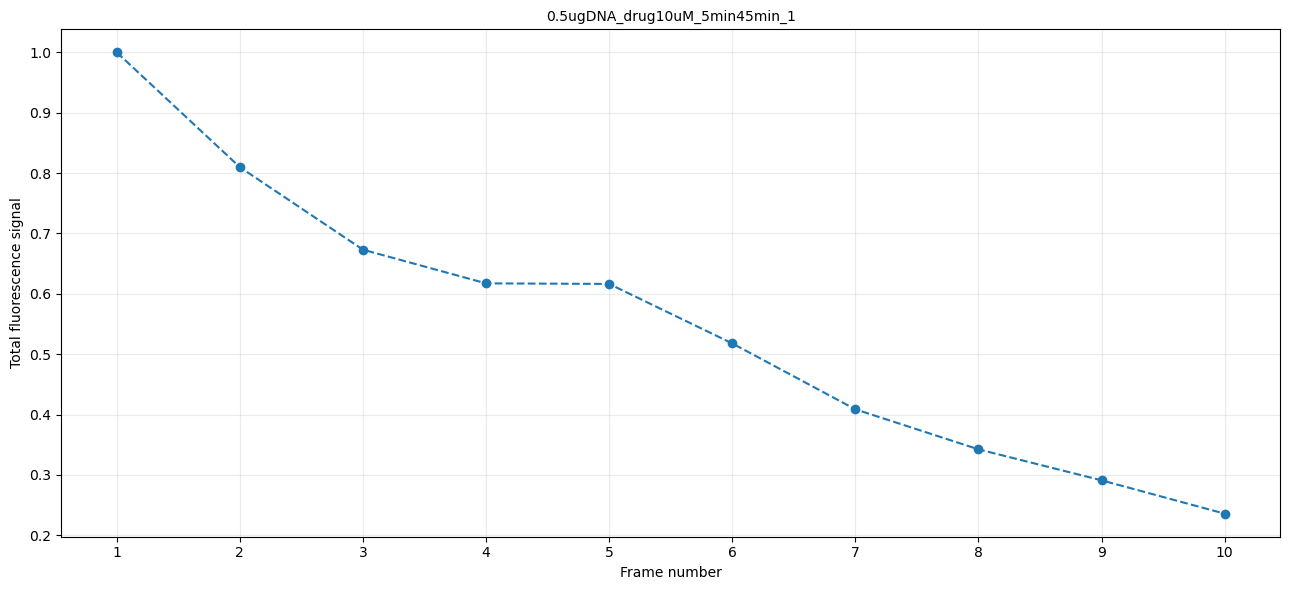

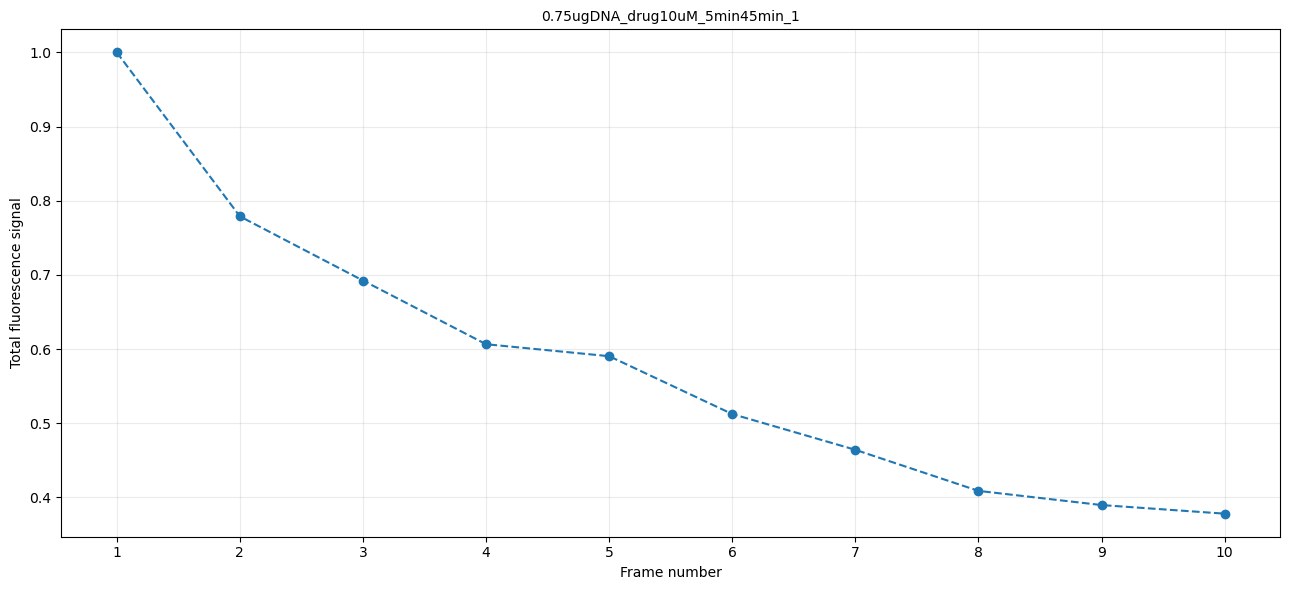

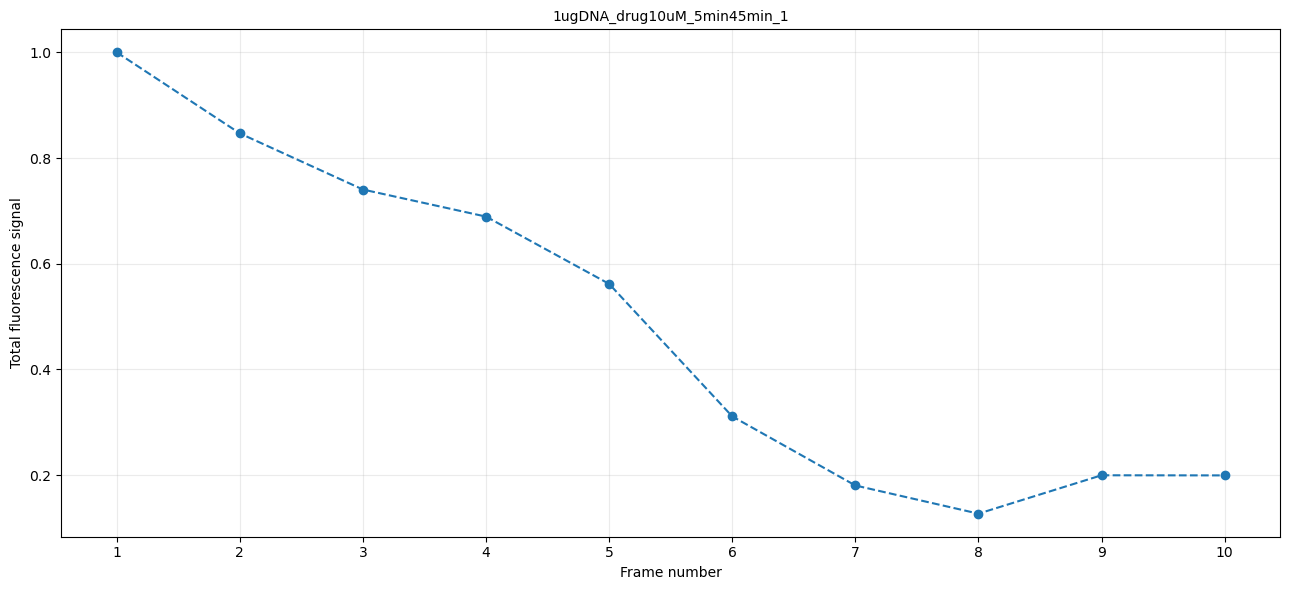

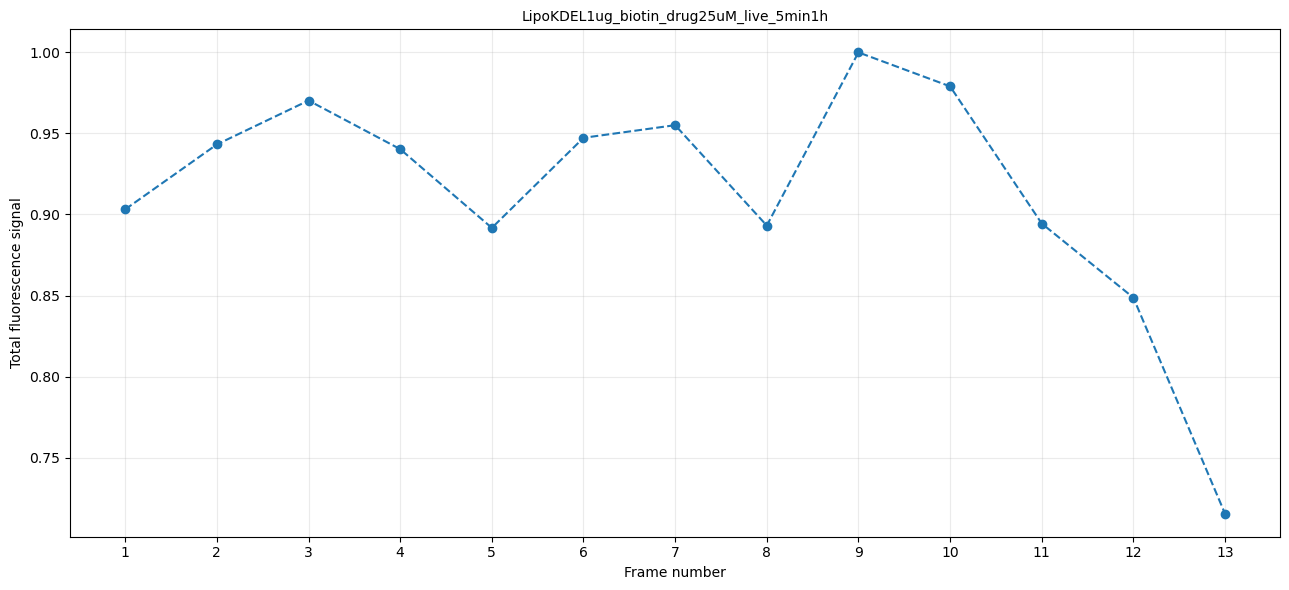

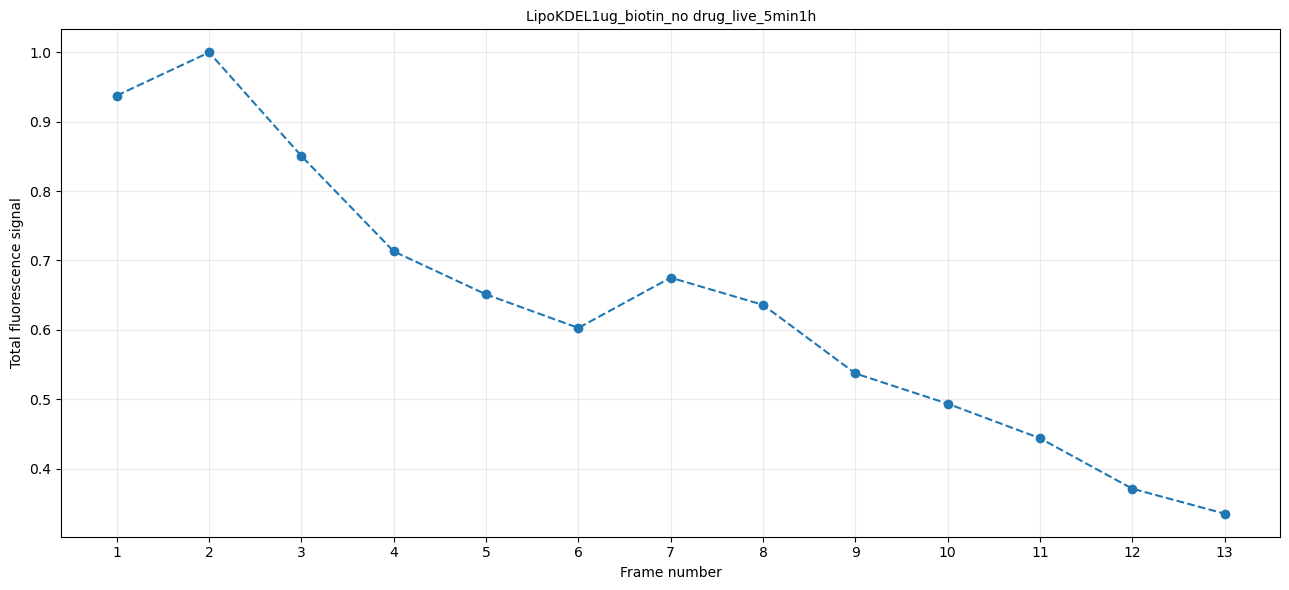

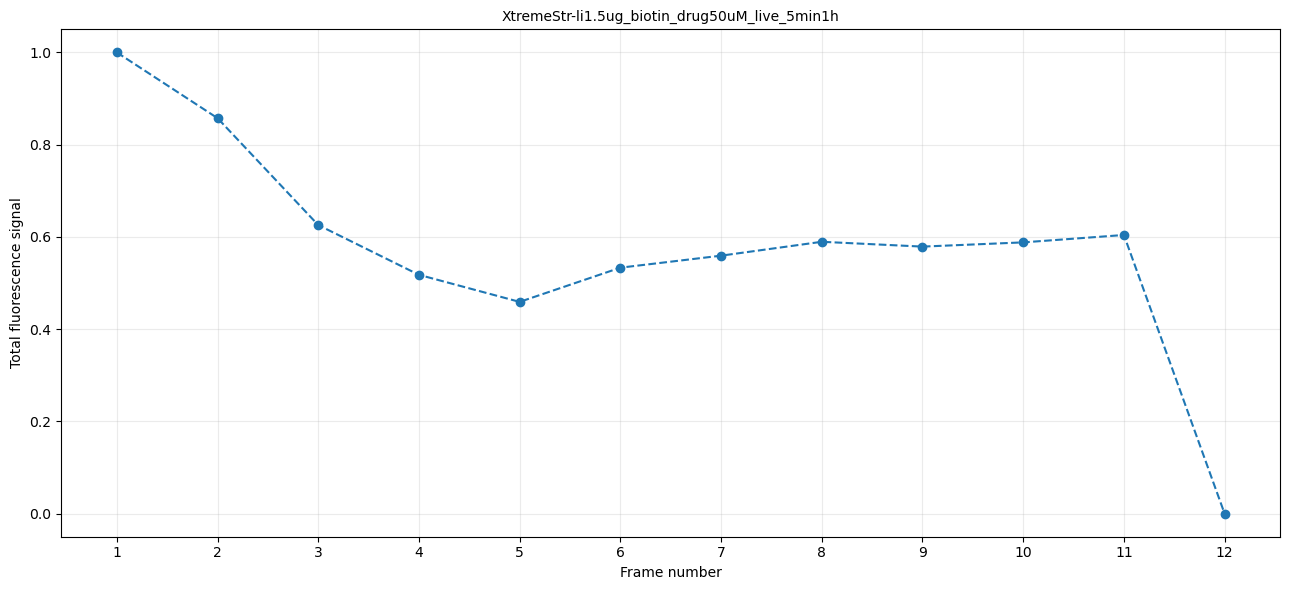

In [54]:
# This works, for our new approach.
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] 
#using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

folders_to_process = ('LipoKDEL1ug_biotin_no drug_live_5min1h',  'LipoKDEL1ug_biotin_drug25uM_live_5min1h', 
                      'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h',
                      '0.5ugDNA_drug10uM_5min45min_1', '0.75ugDNA_drug10uM_5min45min_1', '1ugDNA_drug10uM_5min45min_1')

testing = {'0.5ugDNA_drug10uM_5min45min_1': [(300,500, 400,600)],
           '0.75ugDNA_drug10uM_5min45min_1': [(300,475, 375,550)],
           '1ugDNA_drug10uM_5min45min_1': [(400,550, 180,300)],
           'LipoKDEL1ug_biotin_drug25uM_live_5min1h': [(625,740, 600,720)],
           'LipoKDEL1ug_biotin_no drug_live_5min1h': [(550,690, 450,600)],
           'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': [(85,400, 70,150)]
}
         #   'Videos\\XtremeStr-li1.5ug_biotin_no drug_live_5min45min': []
         # }

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

#creating a function called extract_fluorescenceData, to loop through the 7 different folders.
def extract_fluorescenceData(folder_path, img_order, resolutions): 
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith('.jpg'): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function

def histogrammer(video1, n): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames.
    name = os.path.split(n) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1

    #plotting segment
    plt.figure(figsize = (13, 6)) #setting the figure size, has to be before plt.plot
    plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.

    #Labels & aesthetics
    plt.xticks(x) #this makes it show every tick in X axis
    plt.xlabel('Frame number', fontsize = 10)
    plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.title(name[1], fontsize = 10) #name[1] as my first index will be my path, second index is filename
    plt.tight_layout()
    # plt.savefig(f'Graph for {name[1]}.jpg', dpi = 300) #added saving of plots!
    plt.show() #visualisation purposes only, for the output

for key in testing.keys():
    for i in range(len(testing[key])):
        video1 = extract_fluorescenceData(key, vf_dict[key], testing[key][i])
        histogrammer(video1, key)

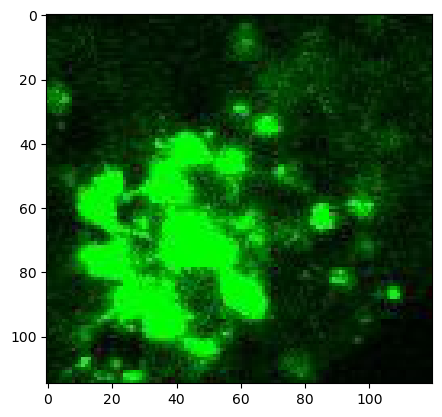

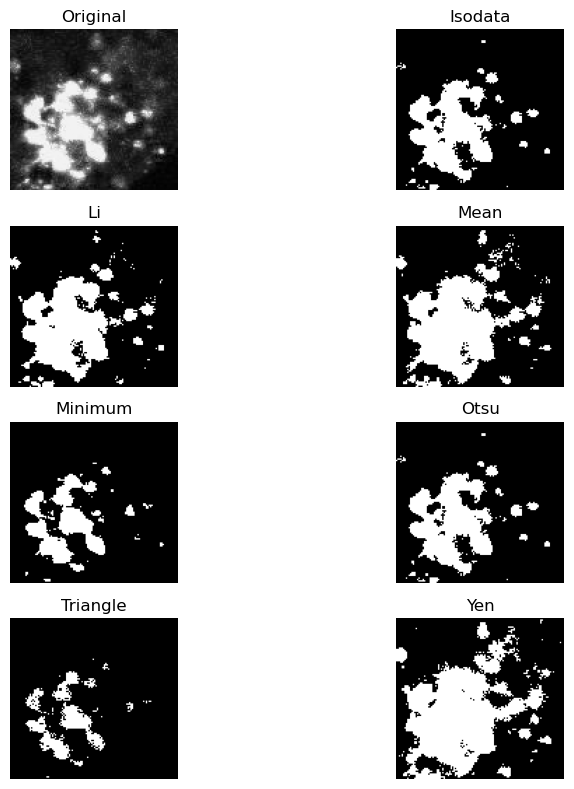

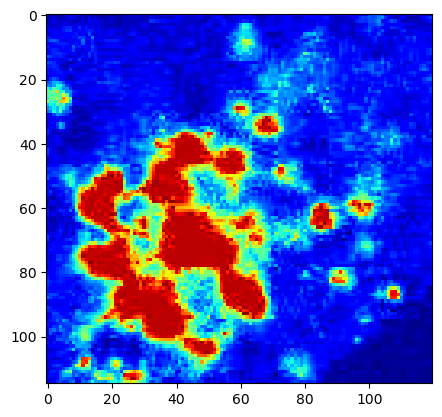

In [48]:
#goal: identify green regions and calculate area to intensity ratio for lipoKDEL1ug_biotin_drug25uM
video = {'LipoKDEL1ug_biotin_drug25uM_live_5min1h': (625,740, 600,720)}

img_path = 'LipoKDEL1ug_biotin_drug25uM_live_5min1h_frame_03.jpg'
img = plt.imread(os.path.join('Videos',list(video.keys())[0], img_path))
img = img[625:740,600:720]
plt.imshow(img)

img_grey = rgb2gray(img)

plt.hist(img_grey, bins = 100)
plt.show()

fig, ax = try_all_threshold(img_grey, figsize=(10, 8), verbose=False)
plt.show()

plt.imshow(img_grey, cmap='jet')
plt.show()

12079.0
---------- Region 0 ----------
Centre	: (54.99279741700472, 62.17700140740128)
Area	: 12079.0


---------- Region 1 ----------
Centre	: (84.0, 34.5)
Area	: 2.0




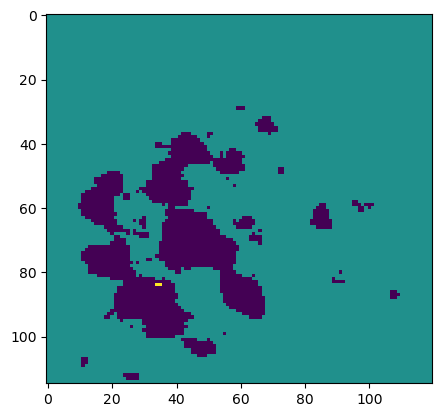

In [52]:
threshold = threshold_minimum(img_grey)
img_binarised = img_grey < threshold

img_labelled = measure.label(img_binarised.astype('uint8'))
plt.imshow(img_labelled)
 # measure.label() requires an image of type int
img_labelled = measure.label(img_binarised.astype('uint8'))
region_info = measure.regionprops(img_labelled)
print(region_info[0].area)

no_of_regions = len(region_info)

for count, region in enumerate(region_info):
    print('-'*10, f'Region {count}', '-'*10)
    print(f'Centre\t: {region.centroid}')
    print(f'Area\t: {region.area}')             # What is the area
    print('\n')

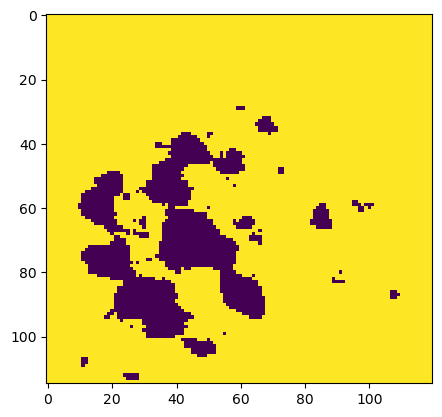

In [49]:
img_masked = img_labelled == 1
plt.imshow(img_masked)
plt.show()

[(625, 740, 600, 720)]


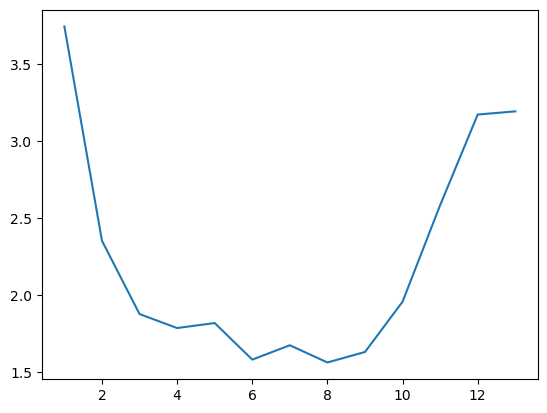

In [59]:
def modified_fluorescenceDataExtract(folder_path, img_order, resolutions): 
    total_fluorescence, areas = [], []
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if img.lower().endswith('.jpg'): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                
                threshold = threshold_minimum(cropped_img)
                binarised_img = cropped_img < threshold
                img_labelled = measure.label(binarised_img.astype('uint8'))
                region_info = measure.regionprops(img_labelled)
                
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
                areas.append((y2-y1)*(x2-x1) - region_info[0].area)
    else:
        print(f'Subdirectory {video_folders} not found')
    ratio = np.array(total_fluorescence)/np.array(areas)
    return total_fluorescence, ratio


key = list(video.keys())[0]
print(testing[key])
total_f, ratios = modified_fluorescenceDataExtract(key, vf_dict[key], testing[key][0])
frame_numbers = np.arange(1,len(total_f)+1)
plt.plot(frame_numbers, ratios)